# Evaluation of Lightweight NLP-Based Solution

In this notebook, we evaluate the performance of Lightweight NLP-Based Solution on a classification task involving short textual descriptions.

## Evaluation function

In [ ]:
import os
import json
import time
from tqdm import tqdm
from datetime import datetime
from ai.models.ClassifyPatentNLP import ClassifyPatentNLP

def run_evaluation(model: ClassifyPatentNLP, testset_path: str, output_path: str, treshold=0.18):
    """
    Runs evaluation on a JSONL test dataset, classifying each description and saving results.

    If the specified output path already exists, appends a numeric suffix (_1, _2, ...) 
    to avoid overwriting the existing file.

    For each line in the test set:
        - Extracts the 'description_text' field
        - Measures the prediction time
        - Classifies the description using `classify_description`
        - Saves the enriched line with classification results and prediction time

    At the end, appends a metadata entry containing:
        - model_name
        - testset_path
        - prompt_template_path (if available)
        - creation date

    Args:
        testset_path (str): Path to the input .jsonl test dataset.
        output_path (str): Desired path to save the output .jsonl file.

    Returns:
        None
    """

    def get_safe_output_path(path):
        """Generates a non-conflicting file path by appending a numeric suffix if needed."""
        base, ext = os.path.splitext(path)
        counter = 1
        while os.path.exists(path):
            path = f"{base}_{counter}{ext}"
            counter += 1
        return path

    # Ensure the output file won't overwrite an existing file
    safe_output_path = get_safe_output_path(output_path)

    # Read all lines for progress tracking
    with open(testset_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    with open(safe_output_path, "w", encoding="utf-8") as out_f:
        for line in tqdm(lines, desc="Running evaluation"):
            data = json.loads(line)
            description_text = data.get("description_text", "")

            # Rename sdg in true_sdg
            if "sdg" in data:
                data["true_sdg"] = data.pop("sdg")

            # Time the classification
            start_time = time.time()
            sdg_balise = model.classify_description(description_text, treshold)
            prediction_time = time.time() - start_time

            # Add classification results and timing to the entry
            data.update({
                "sdg_balise": sdg_balise,
                "prediction_time": prediction_time
            })

            # Write enriched data to output
            out_f.write(json.dumps(data) + "\n")

        # Append metadata at the end
        meta_data = {
            "meta_data": {
                "model_name": model.model_name,
                "testset_path": testset_path,
                "date_creation": datetime.now().isoformat()
            }
        }
        out_f.write(json.dumps(meta_data) + "\n")

2025-05-27 00:14:42,215 - httpx - INFO - _send_single_request - HTTP Request: GET http://localhost:11434/api/tags "HTTP/1.1 200 OK"


In [ ]:
import re

def extract_all_sdgs(text):
    """
    Extracts all SDGs found in a text and returns them as a standardized list.
    
    This function detects multiple SDG references in various formats including:
    - SDG followed by number (e.g., "SDG1", "SDG 2")
    - Numbers with sub-targets (e.g., "16.1", "3.4")
    - Standalone numbers at the beginning or after delimiters
    - Case-insensitive matching
    
    Args:
        text (str): The input text to analyze
        
    Returns:
        list: A list of unique SDGs found in the format ["SDG1", "SDG2", ...], 
            sorted numerically, or empty list if none found
    """
    if not text or not isinstance(text, str):
        return ["None"]
    
    sdg_numbers = set()  # Use set to avoid duplicates
    
    # Pattern 1: SDG followed by number with optional sub-target
    # Captures: SDG1, sdg 2, SDG13.4, etc.
    sdg_pattern = r'(?i)\bsdg\s*(\d{1,2})(?:\.\d+)?\b'
    sdg_matches = re.findall(sdg_pattern, text)
    for match in sdg_matches:
        number = int(match)
        if 1 <= number <= 17:
            sdg_numbers.add(number)
    
    # Pattern 2: Number with sub-target (e.g., "16.1", "3.4")
    # Look for patterns like X.Y where X is 1-17
    number_with_sub_pattern = r'\b(\d{1,2})\.\d+\b'
    sub_matches = re.findall(number_with_sub_pattern, text)
    for match in sub_matches:
        number = int(match)
        if 1 <= number <= 17:
            sdg_numbers.add(number)
    
    # Pattern 3: Standalone numbers at beginning or after delimiters
    # More careful matching to avoid false positives
    # Look for numbers that are:
    # - At the start of the string followed by delimiter or end
    # - After comma/semicolon/colon followed by delimiter or end
    # - After whitespace followed by delimiter or end
    standalone_pattern = r'(?:^|[,;:]\s*|(?<=\s))(\d{1,2})(?=\s*[,;]|\s*$|\s+)'
    standalone_matches = re.findall(standalone_pattern, text.strip())
    for match in standalone_matches:
        number = int(match)
        if 1 <= number <= 17:
            sdg_numbers.add(number)
    
    # Convert to sorted list of formatted strings
    result = [f"SDG{num}" for num in sorted(sdg_numbers)]

    return ["None"] if not result else result

In [ ]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from collections import defaultdict
from pathlib import Path
import numpy as np
import re

def analyse_lists(list1, list2):
    """
    Compare two lists and return similarity metrics.

    Args:
        list1 (list): First list (e.g., true SDGs)
        list2 (list): Second list (e.g., predicted SDGs)

    Returns:
        tuple: (number of unique elements, number of common elements)
    """
    unique_count = len(set(list1) | set(list2))
    common_count = len(set(list1) & set(list2))
    return unique_count, common_count


def compare_models_evaluation(evaluation_paths: list, extract_all_sdgs_func=None):
    """
    Compare multiple model evaluations from JSONL files using custom accuracy based on list overlap.

    Args:
        evaluation_paths (list): List of paths to JSONL evaluation files
        extract_all_sdgs_func (function): Function to extract SDGs from predictions

    Returns:
        dict: Dictionary containing comparison results and DataFrames
    """
    
    # Default SDG extraction function
    if extract_all_sdgs_func is None:
        def extract_all_sdgs_func(sdg_string):
            if not sdg_string:
                return []
            return list(set(re.findall(r'SDG\d+', str(sdg_string))))

    models_results = {}
    comparison_data = []

    # Process each model file
    for eval_path in evaluation_paths:
        model_name = Path(eval_path).stem  # Model name from filename

        total_predictions = 0
        cumulative_accuracy = 0.0
        total_time = 0.0
        sdg_breakdown = defaultdict(lambda: {"accuracy_sum": 0.0, "count": 0})
        meta_data = {}

        with open(f"../src/ai/evaluations/{eval_path}", "r", encoding="utf-8") as f:
            for line in f:
                data = json.loads(line)

                if "meta_data" in data:
                    meta_data = data["meta_data"]
                    continue

                if "patent_number" in data:
                    true_sdgs = extract_all_sdgs_func(data.get("true_sdg", ""))
                    predicted_sdgs = extract_all_sdgs_func(data.get("sdg_balise", ""))

                    num_unique, num_common = analyse_lists(true_sdgs, predicted_sdgs)
                    accuracy = num_common / num_unique if num_unique > 0 else 0.0

                    total_predictions += 1
                    cumulative_accuracy += accuracy
                    total_time += data.get("prediction_time", 0.0)

                    for sdg in true_sdgs:
                        sdg_breakdown[sdg]["accuracy_sum"] += accuracy
                        sdg_breakdown[sdg]["count"] += 1

        avg_accuracy = cumulative_accuracy / total_predictions if total_predictions > 0 else 0.0
        avg_prediction_time = total_time / total_predictions if total_predictions > 0 else 0.0
        predictions_per_second = total_predictions / total_time if total_time > 0 else 0.0

        models_results[model_name] = {
            "accuracy": avg_accuracy,
            "total_predictions": total_predictions,
            "total_time": total_time,
            "avg_prediction_time": avg_prediction_time,
            "predictions_per_second": predictions_per_second,
            "sdg_breakdown": {
                sdg: {
                    "avg_accuracy": stats["accuracy_sum"] / stats["count"]
                    if stats["count"] > 0 else 0.0,
                    "count": stats["count"]
                }
                for sdg, stats in sdg_breakdown.items()
            },
            "meta_data": meta_data
        }

        comparison_data.append({
            "Model": model_name,
            "Accuracy": avg_accuracy,
            "Total Predictions": total_predictions,
            "Avg Prediction Time (s)": avg_prediction_time,
            "Predictions/sec": predictions_per_second
        })

    # Create summary DataFrame
    comparison_df = pd.DataFrame(comparison_data)

    print("=== MODEL COMPARISON SUMMARY ===")
    print(comparison_df.round(4).to_string(index=False))
    print()

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

    # 1. Accuracy Bar Chart
    ax1 = axes[0, 0]
    bars1 = ax1.bar(comparison_df['Model'], comparison_df['Accuracy'], 
                    color=plt.cm.viridis(np.linspace(0, 1, len(comparison_df))))
    ax1.set_title('Model Accuracy Comparison')
    ax1.set_ylabel('Accuracy')
    ax1.set_ylim(0, 1)
    for bar in bars1:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.3f}', ha='center', va='bottom')
    plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')

    # 2. Speed Comparison
    ax2 = axes[0, 1]
    bars2 = ax2.bar(comparison_df['Model'], comparison_df['Predictions/sec'],
                    color=plt.cm.plasma(np.linspace(0, 1, len(comparison_df))))
    ax2.set_title('Model Speed Comparison')
    ax2.set_ylabel('Predictions per Second')
    for bar in bars2:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                 f'{height:.2f}', ha='center', va='bottom')
    plt.setp(ax2.get_xticklabels(), rotation=45, ha='right')

    # 3. SDG-specific Accuracy Heatmap
    ax3 = axes[1, 0]
    sdg_comparison_data = []
    for model, result in models_results.items():
        for sdg, stats in result["sdg_breakdown"].items():
            sdg_comparison_data.append({
                "Model": model,
                "SDG": sdg,
                "Accuracy": stats["avg_accuracy"],
                "Count": stats["count"]
            })

    if sdg_comparison_data:
        sdg_df = pd.DataFrame(sdg_comparison_data)
        sdg_pivot = sdg_df.pivot(index="SDG", columns="Model", values="Accuracy")
        sns.heatmap(sdg_pivot, annot=True, fmt='.3f', cmap='RdYlGn', 
                    ax=ax3, cbar_kws={'label': 'Accuracy'})
        ax3.set_title('SDG-Specific Accuracy Comparison')
        ax3.set_xlabel('Model')
        ax3.set_ylabel('SDG')
        ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
    
    # 4. Accuracy vs Speed Scatter Plot
    ax4 = axes[1, 1]
    scatter = ax4.scatter(comparison_df['Avg Prediction Time (s)'], 
                        comparison_df['Accuracy'],
                        s=100, alpha=0.7, c=range(len(comparison_df)), 
                        cmap='tab10')

    # Obtenir les limites de l'axe pour ne pas sortir du cadre
    x_min, x_max = ax4.get_xlim()
    y_min, y_max = ax4.get_ylim()

    for i, model in enumerate(comparison_df['Model']):
        x = comparison_df.iloc[i]['Avg Prediction Time (s)']
        y = comparison_df.iloc[i]['Accuracy']
        
        # Offset par défaut
        dx = 5
        dy = 5
        ha = 'left'
        va = 'bottom'
        
        # Ajustement pour rester dans les bornes
        if x > x_max * 0.95:
            dx = -5
            ha = 'right'
        elif x < x_min * 1.05:
            dx = 5
            ha = 'left'
            
        if y > y_max * 0.95:
            dy = -5
            va = 'top'
        elif y < y_min * 1.05:
            dy = 5
            va = 'bottom'

        ax4.annotate(model, 
                    (x, y),
                    xytext=(dx, dy), textcoords='offset points',
                    fontsize=9,
                    ha=ha, va=va)

    ax4.set_title('Accuracy vs Speed Trade-off')
    ax4.set_xlabel('Average Prediction Time (seconds)')
    ax4.set_ylabel('Accuracy')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


    # SDG Summary Table
    if sdg_comparison_data:
        print("\n=== DETAILED SDG BREAKDOWN ===")
        sdg_summary = sdg_df.groupby('SDG').agg({
            'Accuracy': ['mean', 'std', 'min', 'max'],
            'Count': 'sum'
        }).round(4)
        print(sdg_summary)

        # Best and worst SDGs
        sdg_mean_accuracy = sdg_df.groupby('SDG')['Accuracy'].mean().sort_values(ascending=False)
        print(f"\nBest performing SDGs:")
        for sdg, acc in sdg_mean_accuracy.head(3).items():
            print(f"  {sdg}: {acc:.3f}")
        print(f"\nWorst performing SDGs:")
        for sdg, acc in sdg_mean_accuracy.tail(3).items():
            print(f"  {sdg}: {acc:.3f}")

    # Ranking based on accuracy and speed
    print(f"\n=== MODEL RANKING ===")
    ranking_df = comparison_df.copy()
    ranking_df['Accuracy_Rank'] = ranking_df['Accuracy'].rank(ascending=False)
    ranking_df['Speed_Rank'] = ranking_df['Predictions/sec'].rank(ascending=False)
    ranking_df['Overall_Score'] = (ranking_df['Accuracy_Rank'] + ranking_df['Speed_Rank']) / 2
    ranking_df = ranking_df.sort_values('Overall_Score')

    print("Overall Ranking (accuracy + speed):")
    for i, row in ranking_df.iterrows():
        print(f"{int(row['Overall_Score'])}. {row['Model']} "
              f"(Accuracy: {row['Accuracy']:.3f}, Speed: {row['Predictions/sec']:.2f})")

    return {
        "comparison_df": comparison_df,
        "models_results": models_results,
        "sdg_comparison_df": pd.DataFrame(sdg_comparison_data) if sdg_comparison_data else None,
        "ranking_df": ranking_df
    }


## Models

In [ ]:
# Imports
from ai.models.model_v010 import ClassifyPatentNLP
from api.config.ai_config import ai_huggingface_token

In [3]:
# Evaluate facebook/bart-large-mnli
model = ClassifyPatentNLP(ai_huggingface_token=ai_huggingface_token,
                          model_name="facebook/bart-large-mnli")
run_evaluation(model=model, testset_path="../src/ai/testsets/testset_v3_en_labeled.jsonl", 
               output_path="../src/ai/evaluations/nlp_bart-large-mnli.jsonl",
               treshold=0.18)

Device set to use cuda:0
Running evaluation: 100%|██████████| 328/328 [02:45<00:00,  1.99it/s]


In [5]:
# Evaluate sileod/deberta-v3-base-tasksource-nli
model = ClassifyPatentNLP(ai_huggingface_token=ai_huggingface_token,
                            model_name="sileod/deberta-v3-base-tasksource-nli")
run_evaluation(model=model, testset_path="../src/ai/testsets/testset_v3_en_labeled.jsonl", 
               output_path="../src/ai/evaluations/deberta-v3-base-tasksource-nli.jsonl",
               treshold=0.1)

Device set to use cuda:0
Running evaluation: 100%|██████████| 328/328 [03:08<00:00,  1.74it/s]


In [14]:
# Evaluate FacebookAI/roberta-large-mnli
model = ClassifyPatentNLP(ai_huggingface_token=ai_huggingface_token,
                            model_name="FacebookAI/roberta-large-mnli")
run_evaluation(model=model, testset_path="../src/ai/testsets/testset_v3_en_labeled.jsonl", 
               output_path="../src/ai/evaluations/roberta-large-mnli.jsonl",
               treshold=0.0)

Some weights of the model checkpoint at FacebookAI/roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cuda:0
Running evaluation:  64%|██████▍   | 211/328 [06:32<01:05,  1.78it/s]

## Plot Evaluation

=== MODEL COMPARISON SUMMARY ===
                         Model  Accuracy  Total Predictions  Avg Prediction Time (s)  Predictions/sec
           llm_prompt_short_4b    0.5833                328                  11.4127           0.0876
           nlp_bart-large-mnli    0.4360                328                   0.5025           1.9901
deberta-v3-base-tasksource-nli    0.2439                328                   0.5744           1.7410
            roberta-large-mnli    0.1829                328                   1.6014           0.6244



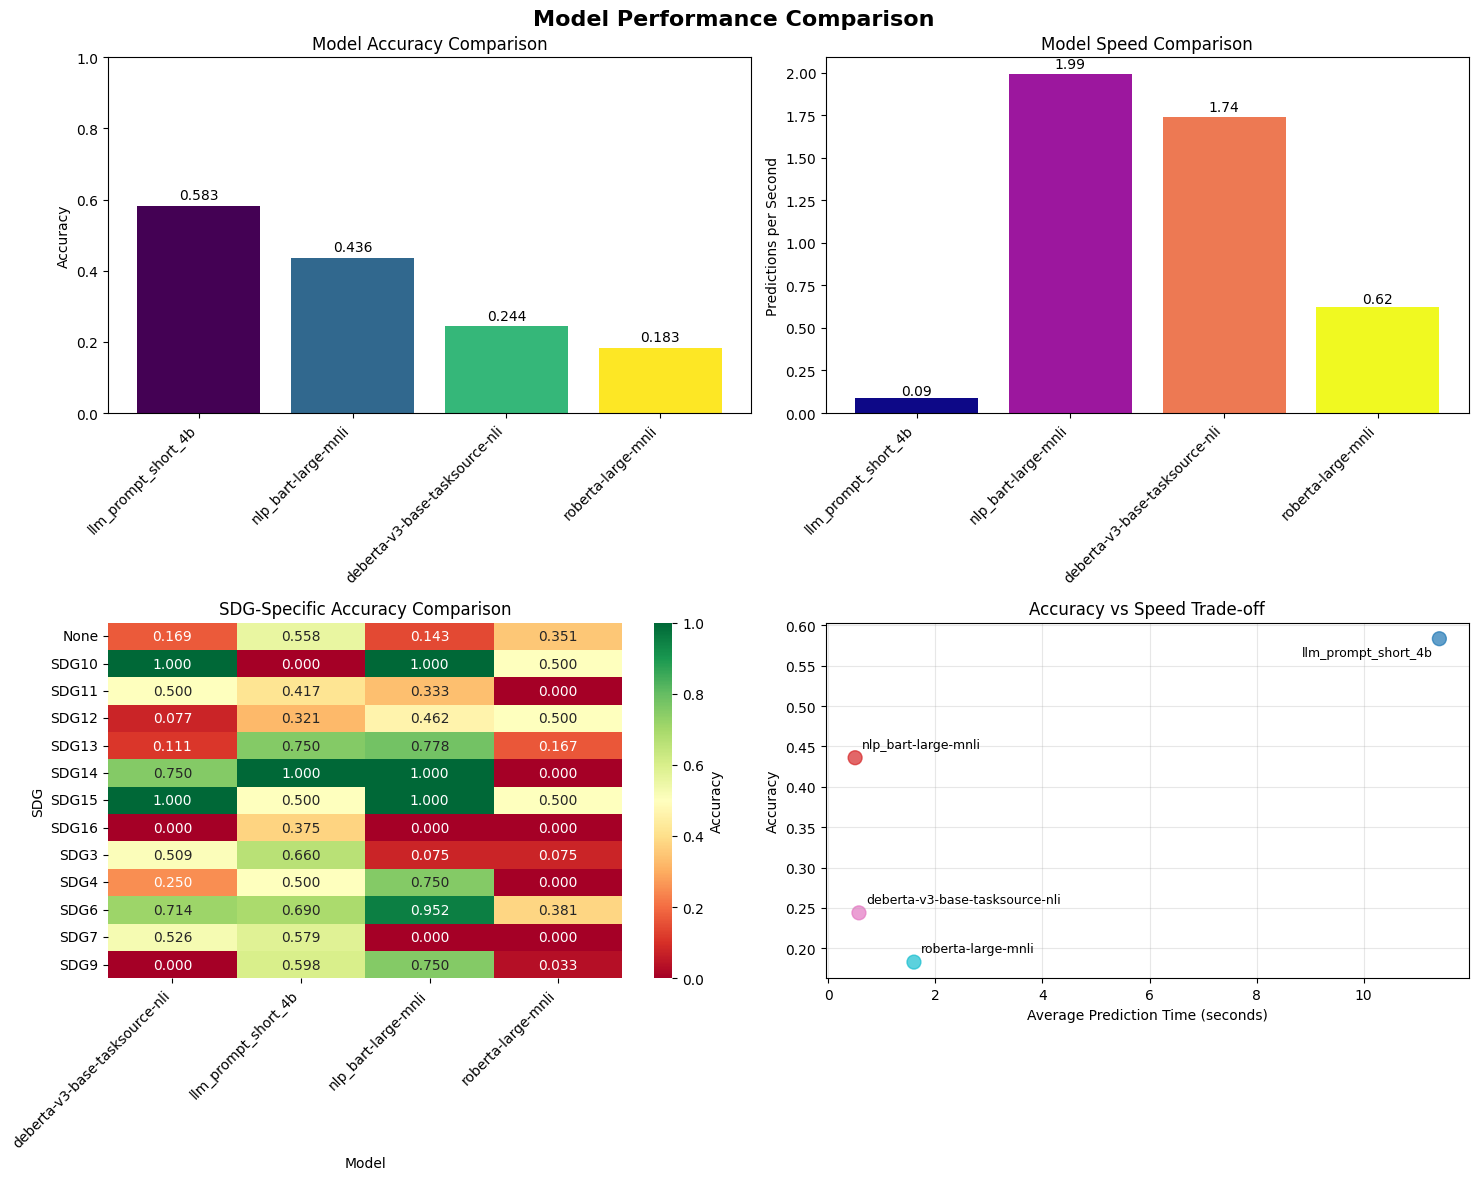


=== DETAILED SDG BREAKDOWN ===
      Accuracy                         Count
          mean     std     min     max   sum
SDG                                         
None    0.3052  0.1925  0.1429  0.5584   308
SDG10   0.6250  0.4787  0.0000  1.0000     8
SDG11   0.3125  0.2192  0.0000  0.5000    24
SDG12   0.3397  0.1915  0.0769  0.5000   104
SDG13   0.4514  0.3617  0.1111  0.7778    72
SDG14   0.6875  0.4732  0.0000  1.0000    16
SDG15   0.7500  0.2887  0.5000  1.0000     8
SDG16   0.0938  0.1875  0.0000  0.3750    16
SDG3    0.3302  0.3005  0.0755  0.6604   212
SDG4    0.3750  0.3227  0.0000  0.7500    16
SDG6    0.6845  0.2344  0.3810  0.9524    84
SDG7    0.2763  0.3198  0.0000  0.5789    76
SDG9    0.3451  0.3849  0.0000  0.7500   368

Best performing SDGs:
  SDG15: 0.750
  SDG14: 0.688
  SDG6: 0.685

Worst performing SDGs:
  None: 0.305
  SDG7: 0.276
  SDG16: 0.094

=== MODEL RANKING ===
Overall Ranking (accuracy + speed):
1. nlp_bart-large-mnli (Accuracy: 0.436, Speed: 1.99)
2

In [22]:
# Exemple d'utilisation:
results = compare_models_evaluation([
    "llm_prompt_short_4b.jsonl",
    "nlp_bart-large-mnli.jsonl",
    "deberta-v3-base-tasksource-nli.jsonl",
    "roberta-large-mnli.jsonl"
], extract_all_sdgs_func=extract_all_sdgs)

=== MODEL COMPARISON SUMMARY ===
                         Model  Accuracy  Total Predictions  Avg Prediction Time (s)  Predictions/sec
           llm_prompt_short_4b    0.5833                328                  11.4127           0.0876
           nlp_bart-large-mnli    0.4360                328                   0.5025           1.9901
deberta-v3-base-tasksource-nli    0.2439                328                   0.5744           1.7410
            roberta-large-mnli    0.1829                328                   1.6014           0.6244



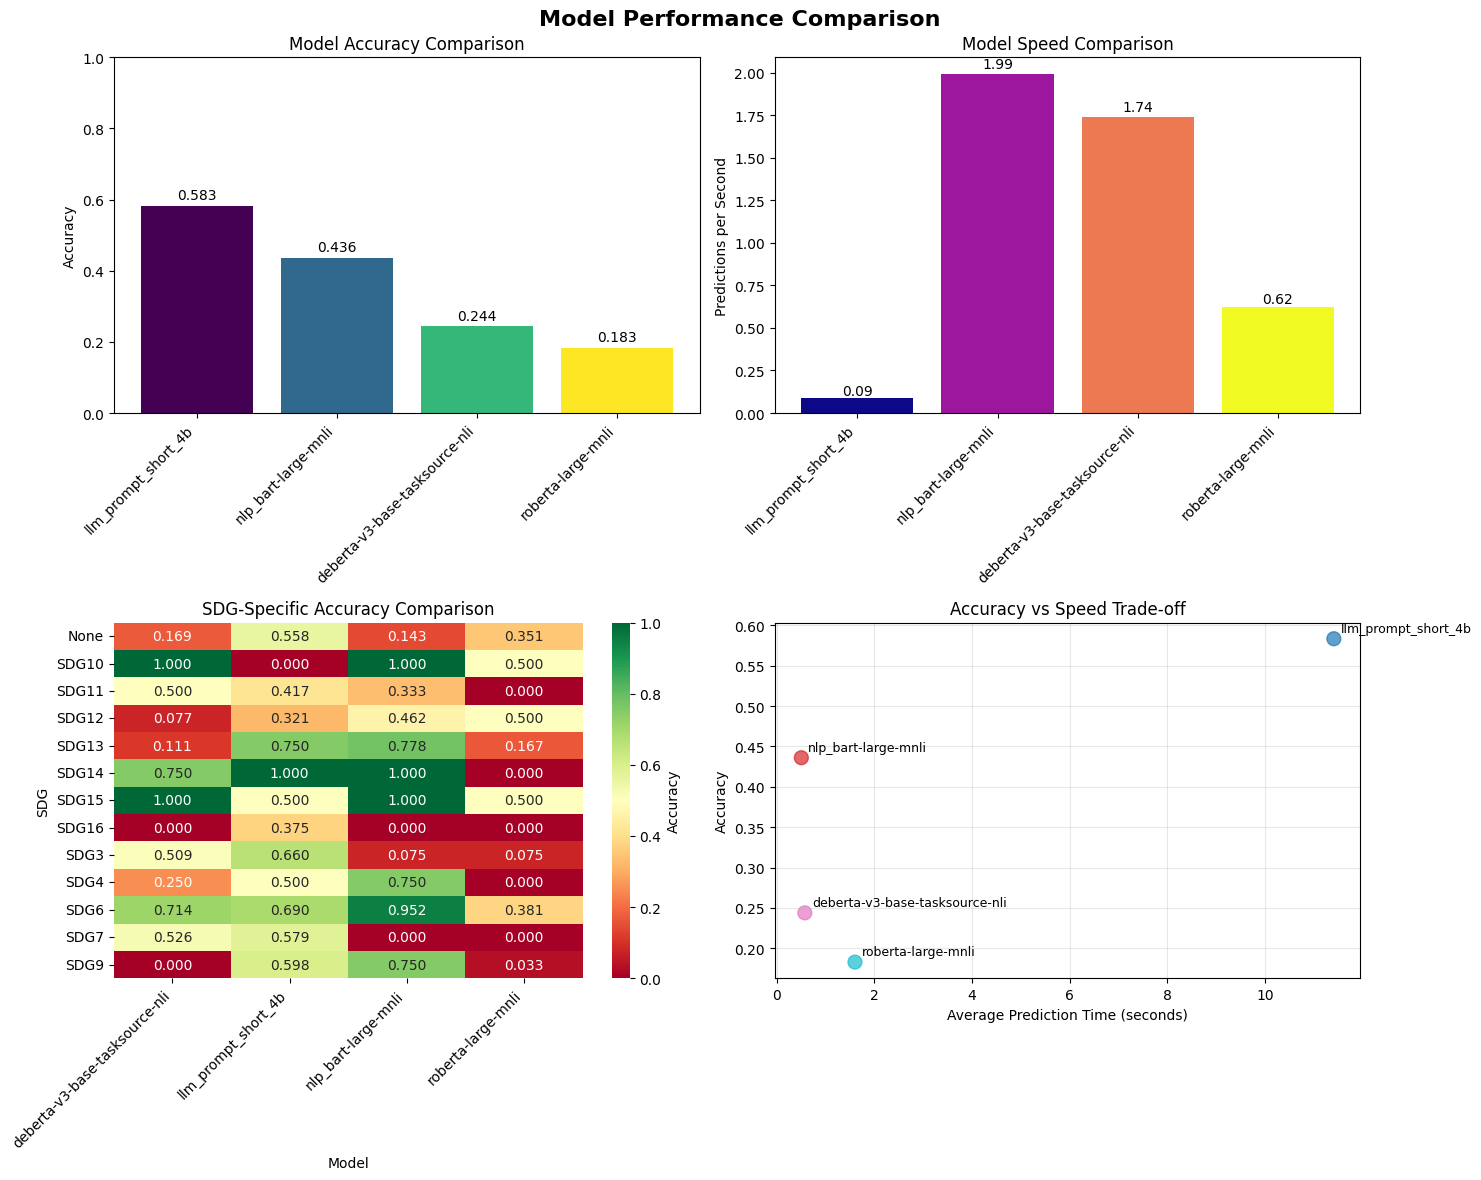


=== DETAILED SDG BREAKDOWN ===
      Accuracy                         Count
          mean     std     min     max   sum
SDG                                         
None    0.3052  0.1925  0.1429  0.5584   308
SDG10   0.6250  0.4787  0.0000  1.0000     8
SDG11   0.3125  0.2192  0.0000  0.5000    24
SDG12   0.3397  0.1915  0.0769  0.5000   104
SDG13   0.4514  0.3617  0.1111  0.7778    72
SDG14   0.6875  0.4732  0.0000  1.0000    16
SDG15   0.7500  0.2887  0.5000  1.0000     8
SDG16   0.0938  0.1875  0.0000  0.3750    16
SDG3    0.3302  0.3005  0.0755  0.6604   212
SDG4    0.3750  0.3227  0.0000  0.7500    16
SDG6    0.6845  0.2344  0.3810  0.9524    84
SDG7    0.2763  0.3198  0.0000  0.5789    76
SDG9    0.3451  0.3849  0.0000  0.7500   368

Best performing SDGs:
  SDG15: 0.750
  SDG14: 0.688
  SDG6: 0.685

Worst performing SDGs:
  None: 0.305
  SDG7: 0.276
  SDG16: 0.094

=== MODEL RANKING ===
Overall Ranking (accuracy + speed):
1. nlp_bart-large-mnli (Accuracy: 0.436, Speed: 1.99)
2

In [18]:
# Exemple d'utilisation:
results = compare_models_evaluation([
    "llm_prompt_short_4b.jsonl",
    "nlp_bart-large-mnli.jsonl",
    "deberta-v3-base-tasksource-nli.jsonl",
    "roberta-large-mnli.jsonl"
], extract_all_sdgs_func=extract_all_sdgs)